In [16]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [2]:
def HodHux_ELEC380(I, dt, plot_activation = 0): 

    #Hodgkin Huxley model of a neuron
    #ELEC 480 Fall 2014
    #JTRobinson
    #
    #Converted from MATLAB to Python by CATuppen Fall 2021
    #
    #Input:
    #I = a vector of current values [uA]
    #dt = time step between I measurements [ms]
    #plot_activation (optional) = 1 to plot the activation state variables vs V (default 0)
    #
    #Output:
    #V = membrane voltage in mV
    #n = sodium activation
    #m = potassium activation
    #h = 1 - potassium inactivation
    #Im = membrane current in uA
    #
    #State variables: V, n, m, h
    #
    #DV = 1/C (I - Ik - Ina - Il)
    # 
    # Il = gl(V-El)
    # Ik = gk*n^4(V-Ek)
    # Ina = gna*m^3*h(V-Ena)
    #
    #Dn = (ninf(V) - n)/taun(V)
    #Dm = (minf(V) - m)/taum(V)
    #Dh = (hinf(V) - h)/tauh(V)

    # can move these to outside of function for efficiency if desired
    

    global V
    global m
    global n
    global h
    global gkt
    global gnat
    global Ik
    global Ina
    global Il

    #starting membrane potential;
    Vstart = -65.625 #[mV]

    #Constants:
    #reversal potentials for various ions
    Ek = -77 #[mV]
    Ena = 50 #[mV] 
    El = -54.4 #[mV] H&H used approx -55 mV

    #Membrane capacitance:
    C = 1 #[uF]

    #maximum conductances [mS]
    gna = 120
    gk = 36
    gl = 0.3

    #Constants for GHK eq for channel activation
    #from J. Bossu, J Physiol. 496.2 (1996)
    #V50n = 57;
    #kn = 13.5;

    #from Izhikevich pg. 46 (2007)
    #K+ Delayed Rectifier 1: Ik = g*n^4*(V-Ek)

    #activation
    V50n = -50
    kn = 15

    Vmaxn = -79
    sig_n = 50
    Campn = 4.7
    Cbasen = 1.1

    #from Izhikevich pg. 46 (2007)
    #Na+ Fast Transient 1: Ina = g*m^3*h*(V-Ena)

    #activation:
    V50m = -40
    km = 8 #adjusted to match Fig. 2.3 on Pg. 39. probably a typo in the table 

    Vmaxm = -38
    sig_m = 30
    Campm = 0.46
    Cbasem = 0.04

    #inactivation
    V50h = -60
    kh = -7

    Vmaxh = -67
    sig_h = 20
    Camph = 7.4
    Cbaseh = 1.2

    #initialize the vector sizes
    n = np.zeros(len(I))
    m = np.zeros(len(I))
    h = np.zeros(len(I))
    V = np.zeros(len(I))
    Im = np.zeros(len(I))

    #set initial conditions:
    n[0] = 0.3
    m[0] = 0.006
    h[0] = 0.626
    V[0] = Vstart #[mV]
    
    


    #iterate through the input sequence and calculate the response
    for ii in range(len(I)-1):
        
        #display progress (can remove this block if desired)
        #if (ii % 1000) == 0:
            #print(ii)
            #print(V[ii],n[ii],m[ii],h[ii])

        #update voltage state variable
        #DV = 1/C (I - Ik - Ina - Il)
        
        #units: 
        #I = uA
        #V = mV, g = mS; g*V = uA
        #C = uF 
        #uA/uC*ms = mV

        
        

        #full model
        V[ii+1] = V[ii] + dt/C*(I[ii] - gl*(V[ii]-El) - gk*n[ii]**4*(V[ii]-Ek) 
                                - gna*m[ii]**3*h[ii]*(V[ii]-Ena))

        
        #steady state activation values at the given voltage
        ninf = 1/( 1 + np.exp( (V50n-V[ii])/kn ) )
        minf = 1/( 1 + np.exp( (V50m-V[ii])/km ) )
        hinf = 1/( 1 + np.exp( (V50h-V[ii])/kh ) )
        
        #time constants
        #Izhikevich pg. 45
        taun = Cbasen + Campn*np.exp(-(Vmaxn-V[ii])**2/sig_n**2)
        taum = Cbasem + Campm*np.exp(-(Vmaxm-V[ii])**2/sig_m**2)
        tauh = Cbaseh + Camph*np.exp(-(Vmaxh-V[ii])**2/sig_h**2)
        
        #update activation state variables
        n[ii+1] = n[ii] + dt*(ninf - n[ii])/taun
        m[ii+1] = m[ii] + dt*(minf - m[ii])/taum
        h[ii+1] = h[ii] + dt*(hinf - h[ii])/tauh
        
        #define conductances and currents for this v[ii]
        gkt_ii = gk*n[ii]**4 
        gnat_ii = gna*m[ii]**3*h[ii]
        Ik_ii = gkt_ii*(V[ii]-Ek)
        Ina_ii = gnat_ii * (V[ii] - Ena)
        Il_ii = gl*(V[ii] - El)

        #this is wrong lol.
        Ic_ii = (V[ii+1] - V[ii]) * C / dt
        
        #add em up to get total membrane current
        Im[ii] = Il_ii + Ic_ii + Ina_ii + Ik_ii

    gkt = gk*n**4
    gnat = gna*m**3*h

    Ik = gkt*(V-Ek)
    Ina = gnat*(V-Ena)
    Il = gl*(V-El)

    #Diagnostics
    if plot_activation:
        Vtest = np.arange(-100,11)

        #steady state activation vs Voltage
        ninfV = 1/( 1 + np.exp((V50n-Vtest)/kn))
        minfV = 1/( 1 + np.exp((V50m-Vtest)/km))
        hinfV = 1/( 1 + np.exp((V50h-Vtest)/kh))

        line1, = plt.plot(Vtest, ninfV, color = 'b', label = r'$n_{infty}$')
        line2, = plt.plot(Vtest, minfV, color = 'r', label = r'$m_{infty}$')
        line3, = plt.plot(Vtest, hinfV, color = 'k', label = r'$h_{infty}$')
        plt.legend(handles=[line1, line2, line3])
        plt.suptitle('steady state activations')
        plt.show()
         
        #time constants vs Voltage
        taunV = Cbasen + Campn*np.exp(-(Vmaxn-Vtest)**2/sig_n**2)
        taumV = Cbasem + Campm*np.exp(-(Vmaxm-Vtest)**2/sig_m**2)
        tauhV = Cbaseh + Camph*np.exp(-(Vmaxh-Vtest)**2/sig_h**2)

        line1, = plt.plot(Vtest, taunV, color = 'b', label = r'$tau_{n}$')
        line2, = plt.plot(Vtest, taumV, color = 'r', label = r'$tau_{m}$')
        line3, = plt.plot(Vtest, tauhV, color = 'k', label = r'$tau_{h}$')
        plt.suptitle('activation time constants')
        plt.legend(handles=[line1, line2, line3])
        plt.show()

    return V, Im

In [3]:
inject_time = 60 #inject for 60 ms
I_inject = 10 #10 uA
total_time = 100 #total time of 100 ms

def create_I_list(I_inject, dt, inject_time, total_time):
    '''
    Make current injection of I_inject (mA) for inject_time in intervals of dt. Total_time in ms.
    '''
    I = [I_inject] * int(inject_time / dt) # inject at intervals of dt for inject_time
    I.extend([0]*int((total_time-inject_time) / dt)) #add on inject current of 0 for the rest of the time after injections
    return I

I_1 = create_I_list(I_inject, 0.1, inject_time, total_time) #dt = 0.1
I_01 = create_I_list(I_inject, 0.01, inject_time, total_time) #dt = 0.01
I_001 = create_I_list(I_inject, 0.001, inject_time, total_time) #dt = 0.001

print(len(I_01))

10000


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:145: RuntimeWarning: overflow encountered in exp
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: overflow encountered in exp
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: overflow encountered in exp
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:149: RuntimeWarning: overflow encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:150: RuntimeWarning: overflow encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:151: RuntimeWarning: overflow encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:139: RuntimeWarning: overflow encountered in double_scalars
/shared-libs/python3.7/py-core/lib/python3.7/s

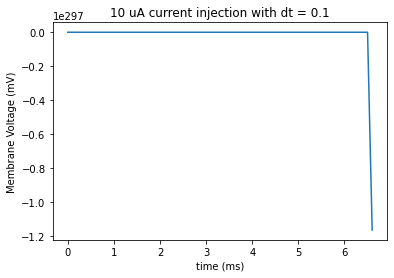

In [4]:
Vm, Im= HodHux_ELEC380(I_1, 0.1, 0)

plt.plot(np.arange(0,100, 0.1), Vm)

print(len(Vm))
plt.xlabel('time (ms)')
plt.ylabel('Membrane Voltage (mV)')
plt.title('10 uA current injection with dt = 0.1')
plt.savefig('Q1.2dt0.1.png')

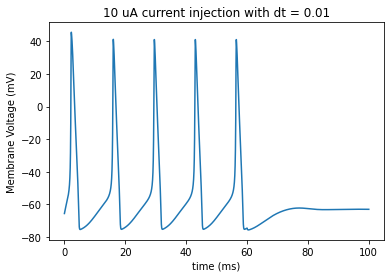

In [5]:
Vm, Im = HodHux_ELEC380(I_01, 0.01, 0)

plt.plot(np.arange(0,100, 0.01), Vm)
plt.xlabel('time (ms)')
plt.ylabel('Membrane Voltage (mV)')
plt.title('10 uA current injection with dt = 0.01')
plt.savefig('Q1.2dt0.01.png')


ValueError: x and y must have same first dimension, but have shapes (60000,) and (100000,)

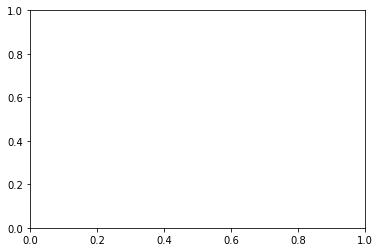

In [14]:
Vm, Im = HodHux_ELEC380(I_001, 0.001, 0)

plt.plot(np.arange(0,100, 0.001), Vm)
plt.xlabel('time (ms)')
plt.ylabel('Membrane Voltage (mV)')
plt.title('10 uA current injection with dt = 0.001')
plt.savefig('Q1.2dt0.001.png')

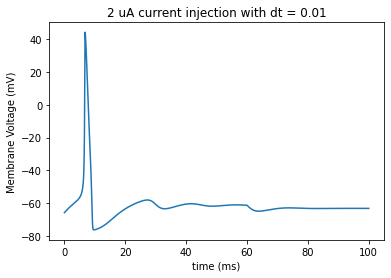

In [7]:
I = create_I_list(2, 0.01, inject_time, total_time) #dt = 0.01

Vm, Im = HodHux_ELEC380(I, 0.01, 0)

plt.plot(np.arange(0,100, 0.01), Vm)
plt.xlabel('time (ms)')
plt.ylabel('Membrane Voltage (mV)')
plt.title('2 uA current injection with dt = 0.01')
plt.savefig('Q1.2dt0.01.png')

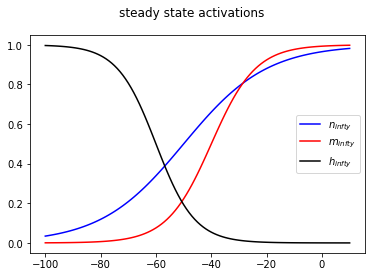

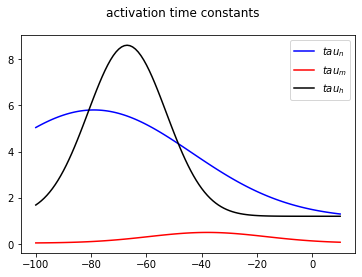

(array([-65.625     , -65.61494757, -65.60490064, ..., -63.03724545,
        -63.03725401, -63.03726256]),
 array([ 1.00000000e+01,  1.00000000e+01,  1.00000000e+01, ...,
        -1.90958360e-14,  3.17346149e-12,  0.00000000e+00]))

In [8]:
HodHux_ELEC380(I_001, 0.001, 1)

In [9]:

def when_action_potential(I_inject, dt, total_time):
    '''
    check when the first action potential occurs
    I_inject: constant input current in uA
    dt: incremental time counter (s)
    total_time: total time recorded (s)
    '''
    time = 0
    mV = -100

    while mV < 0:
        I_list = create_I_list(I_inject, dt, time, total_time)
        V_list, Im= HodHux_ELEC380(I_list, dt, plot_activation = 0) #needs to be if any V in this list is above zero, not just the whole list.
        mV = max(V_list)
        print("mV:" + str(mV) + "," + "time:" + str(time))
        time += dt
        
    return time


when_action_potential(2, 0.1, 10)

mV:-62.40155257807115,time:0
mV:-62.44229584479218,time:0.1
mV:-62.48405752120308,time:0.2
mV:-62.52687646432305,time:0.30000000000000004
mV:-62.57067666631416,time:0.4
mV:-62.61540012500182,time:0.5
mV:-62.61540012500182,time:0.6
mV:-62.66100040559428,time:0.7
mV:-62.707437310910024,time:0.7999999999999999
mV:-62.75465901148112,time:0.8999999999999999
mV:-62.802445349224136,time:0.9999999999999999
mV:-62.85064900374945,time:1.0999999999999999
mV:-62.89837673049578,time:1.2
mV:-62.95563546774229,time:1.3
mV:-62.80721199330029,time:1.4000000000000001
mV:-62.626995656389475,time:1.5000000000000002
mV:-62.44975984533724,time:1.6000000000000003
mV:-62.27528568830118,time:1.7000000000000004
mV:-62.10335472720782,time:1.8000000000000005
mV:-61.933750092137345,time:1.9000000000000006
mV:-61.76625675554557,time:2.0000000000000004
mV:-61.60066121122909,time:2.1000000000000005
mV:-61.436750780562235,time:2.2000000000000006
mV:-61.27431266153094,time:2.3000000000000007
mV:-61.11313278234804,time:

4.6

mV:-62.43094704175956,time:0
mV:-62.43468696975134,time:0.01
mV:-62.43843681082968,time:0.02
mV:-62.44219805911347,time:0.03
mV:-62.44597077801536,time:0.04
mV:-62.44975490547525,time:0.05
mV:-62.45355037688603,time:0.060000000000000005
mV:-62.45735553347466,time:0.07
mV:-62.46117184412891,time:0.08
mV:-62.464999322301345,time:0.09
mV:-62.464999322301345,time:0.09999999999999999
mV:-62.468837896552806,time:0.10999999999999999
mV:-62.47268749434284,time:0.11999999999999998
mV:-62.47654670243769,time:0.12999999999999998
mV:-62.480416577821295,time:0.13999999999999999
mV:-62.48818875061009,time:0.15
mV:-62.49209089882644,time:0.16
mV:-62.496002786212564,time:0.17
mV:-62.49992463066618,time:0.18000000000000002
mV:-62.50385696667871,time:0.19000000000000003
mV:-62.507799720726844,time:0.20000000000000004
mV:-62.51175281976531,time:0.21000000000000005
mV:-62.515716031367035,time:0.22000000000000006
mV:-62.51968826517439,time:0.23000000000000007
mV:-62.52367066157198,time:0.24000000000000007


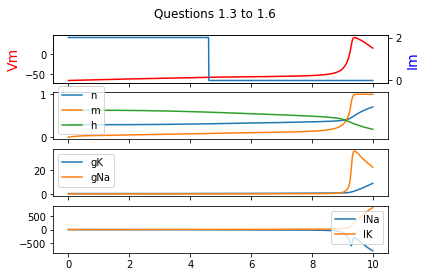

In [13]:
total_time = 10
dt = 0.01
Istim = 2
time = np.arange(0, total_time, dt)

I = create_I_list(Istim, dt, when_action_potential(Istim, dt, total_time), total_time + dt)

print(len(I))
Vm, Im = HodHux_ELEC380(I, dt, 0)

fig, (ax1, ax3, ax4, ax5) = plt.subplots(4, sharex=True)
fig.suptitle('Questions 1.3 to 1.6')

#plot vm
ax1.plot(time, Vm, color="red")
ax1.set_ylabel("Vm",color="red",fontsize=14)

#plot im on same graph
ax2 = ax1.twinx()
ax2.plot(time, Im)
ax2.set_ylabel("Im", color="blue", fontsize=14)

ax3.plot(time, n)
ax3.plot(time, m)
ax3.plot(time, h)
ax3.legend(["n", "m", "h"])

ax4.plot(time, gkt)
ax4.plot(time, gnat)
ax4.legend(['gK', 'gNa'])

ax5.plot(time, Ina)
ax5.plot(time, Ik)
ax5.legend(['INa', 'IK'])
#axs[1].plot(x, -y)

# 1.7
The gating variables are n, m, and h.  
n: sodium activation variable  
m: potassium activation variable  
h: sodium inactivation variable  

h (sodium inactivation) is the gating variable that is responsible for refractory period, because inactivation of sodium channels occurs at the peak of the action potential, and continues through most of the undershoot period. These inactivated channels can't open, even if membrane potential goes above threshold.

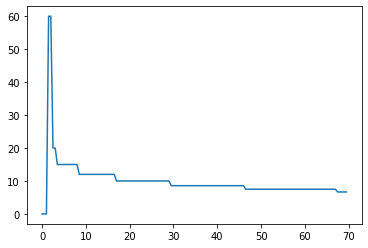

In [23]:
currents = np.arange(0,70,0.5)
I_and_freq_list = []

def find_firing_rate(driving_current):
    I_list = create_I_list(driving_current, 0.01, 60, 60)
    Vm, Im = HodHux_ELEC380(I_list, 0.01, 0)
    peaks, _ = find_peaks(Vm, height=0)

    if len(peaks) == 0:
        frequency = 0
    else:
        frequency = 60 / len(peaks)

    return frequency

for driving_current in currents:
    I_and_freq_list.append((driving_current, find_firing_rate(driving_current)))

driving_currents = [i[0] for i in I_and_freq_list]
frequencies = [i[1] for i in I_and_freq_list]

plt.plot(driving_currents, frequencies)

[(0.0, 0), (0.5, 0), (1.0, 0), (1.5, 60.0), (2.0, 60.0), (2.5, 20.0), (3.0, 20.0), (3.5, 15.0), (4.0, 15.0), (4.5, 15.0), (5.0, 15.0), (5.5, 15.0), (6.0, 15.0), (6.5, 15.0), (7.0, 15.0), (7.5, 15.0), (8.0, 15.0), (8.5, 12.0), (9.0, 12.0), (9.5, 12.0), (10.0, 12.0), (10.5, 12.0), (11.0, 12.0), (11.5, 12.0), (12.0, 12.0), (12.5, 12.0), (13.0, 12.0), (13.5, 12.0), (14.0, 12.0), (14.5, 12.0), (15.0, 12.0), (15.5, 12.0), (16.0, 12.0), (16.5, 12.0), (17.0, 10.0), (17.5, 10.0), (18.0, 10.0), (18.5, 10.0), (19.0, 10.0), (19.5, 10.0), (20.0, 10.0), (20.5, 10.0), (21.0, 10.0), (21.5, 10.0), (22.0, 10.0), (22.5, 10.0), (23.0, 10.0), (23.5, 10.0), (24.0, 10.0), (24.5, 10.0), (25.0, 10.0), (25.5, 10.0), (26.0, 10.0), (26.5, 10.0), (27.0, 10.0), (27.5, 10.0), (28.0, 10.0), (28.5, 10.0), (29.0, 10.0), (29.5, 8.571428571428571), (30.0, 8.571428571428571), (30.5, 8.571428571428571), (31.0, 8.571428571428571), (31.5, 8.571428571428571), (32.0, 8.571428571428571), (32.5, 8.571428571428571), (33.0, 8.5714

# use find peaks for 1.8??? look for discontinuity in firing rate curve, indicative of specific type of neuron

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=4b0ab854-df65-4466-878b-c4c48f502d12' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>